## Object Detection 실습(yolov5)

210509

YOLOv5 : https://github.com/ultralytics/yolov5
        
- 설치(torch는 1.8 version)
> 1. git clone https://github.com/ultralytics/yolov5.git
> 2. cd yolov5
> 3. pip install -r requirements.txt

- YOLOv5x 모델 선정
- 입력이미지 640으로 작고, 그 중에 가장 성능이 좋으면서 추론시간 6ms 가능, 88M개의 파라미터 사용
- [참고](https://dacon.io/competitions/official/235855/codeshare/3743?fbclid=IwAR1ucZ3KBc74hNYC04Lp8omR6wnJ5mwjnQJhFmJh0Pn78x3nTJ-LBmDdPYI)

In [1]:
!git clone https://github.com/airobotlab/lecture_5_yolov5.git
!mv lecture_5_yolov5/* .
!unzip mydata.zip -d ./mydata
!pip install -qr requirements.txt  # install dependencies

Cloning into 'lecture_5_yolov5'...
remote: Enumerating objects: 13226, done.
remote: Total 13226 (delta 0), reused 0 (delta 0), pack-reused 13226
Receiving objects: 100% (13226/13226), 29.64 MiB | 21.57 MiB/s, done.
Resolving deltas: 100% (9189/9189), done.
Archive:  mydata.zip
images/small/국어_2017학년도_11월_30번.jpg:  mismatching "local" filename (images/small/ъ╡ньЦ┤_2017эХЩыЕДыПД_11ьЫФ_30ы▓И.jpg),
         continuing with "central" filename version
  inflating: ./mydata/images/small/국어_2017학년도_11월_30번.jpg  
images/small/국어_2017학년도_11월_32번.jpg:  mismatching "local" filename (images/small/ъ╡ньЦ┤_2017эХЩыЕДыПД_11ьЫФ_32ы▓И.jpg),
         continuing with "central" filename version
  inflating: ./mydata/images/small/국어_2017학년도_11월_32번.jpg  
images/small/국어_2018학년도_11월_24번.jpg:  mismatching "local" filename (images/small/ъ╡ньЦ┤_2018эХЩыЕДыПД_11ьЫФ_24ы▓И.jpg),
         continuing with "central" filename version
  inflating: ./mydata/images/small/국어_2018학년도_11월_24번.jpg  
images/small/국어_2018학년도_3

# Setup

Clone repo, install dependencies and check PyTorch and GPU.

In [2]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla K80)


# 1. Inference

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

<img src="https://user-images.githubusercontent.com/26833433/114307955-5c7e4e80-9ae2-11eb-9f50-a90e39bee53f.png" width="900"> 

In [3]:
!nvidia-smi

Mon May  9 07:11:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%time
!python detect.py --weights yolov5s.pt --img 640 --conf 0.25 --source data/images/ --device 0

detect: weights=['yolov5s.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2022-5-9 torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

100% 14.1M/14.1M [00:00<00:00, 85.3MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
image 1/2 /content/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.031s)
image 2/2 /content/data/images/zidane.jpg: 384x640 2 persons, 2 ties, Done. (0.027s)
Speed: 0.5ms pre-process, 29.0ms inference, 21.1ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp
CPU times: user 141 ms, sys: 32.8 ms, total: 174 ms
Wall time: 17.5 s


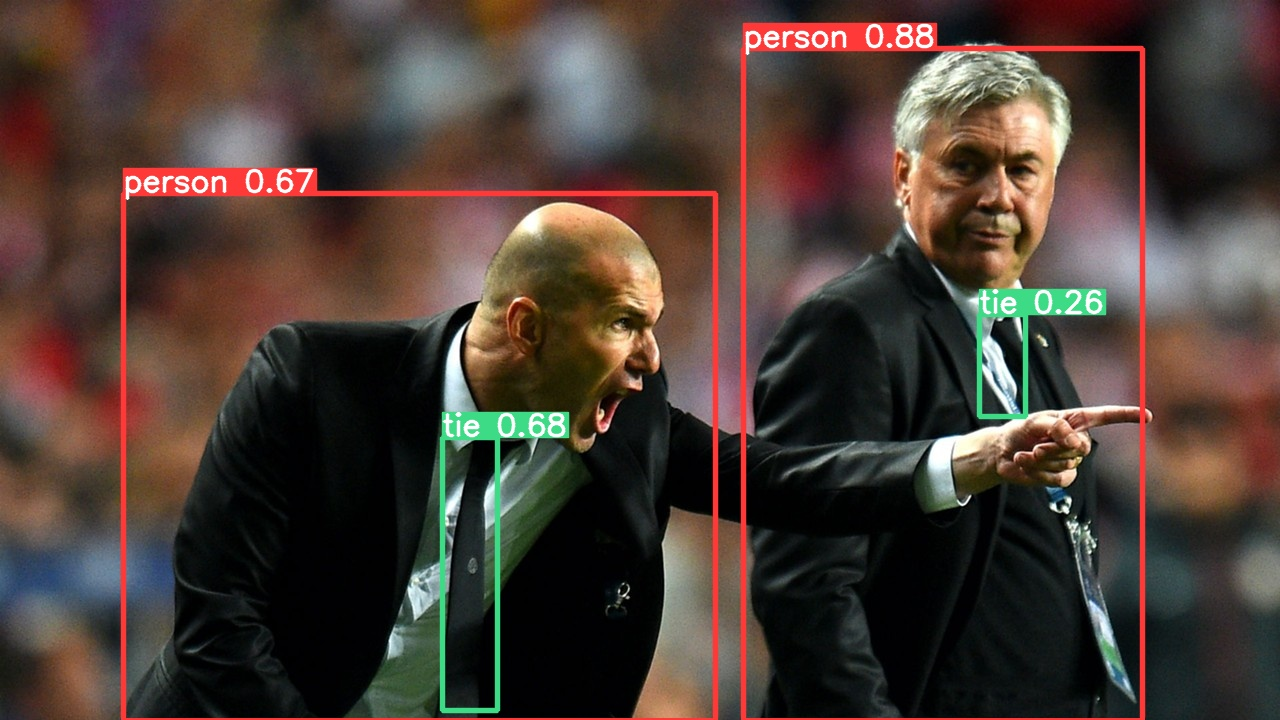

In [5]:
Image(filename='runs/detect/exp/zidane.jpg', width=600)

# 3. OD Train!

210813

# DATA 준비

- mydata 폴더 안에 images, labels 폴더를 준비하자
- 두 폴더 안에는 각각 train/validation/test 폴더를 준비한다
- 아래 yaml 파일에 train에 사용할 폴더를, validation에 사용할 폴더의 경로를 지정한다.
- nc는 물체검출을 위한 클래스의 개수
- names는 각 클래스의 이름


In [6]:
# 데이터 경로와 class 지정, 중요!!
import yaml

data_yaml = dict(
    train = './mydata/images/test/',
    val = './mydata/images/small/',
    nc = 3,
    names = ['question', 'hint', 'answer']
)

# Note that I am creating the file in the yolov5/data/ directory.
with open('data/mydata.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [7]:
## 210812:18:21~(14시간), 모부 OD 데이터 1800개로 학습, 200개로 TEST 시작
# 87.7M params, 175MB weight, 640x640
# https://wandb.ai/keepsteady/YOLOv5/runs/1cturje7
!python train.py --img 640 --batch 8 \
                --epochs 50 \
                --data mydata.yaml \
                --weights yolov5x.pt \
                --cache  # --nosave 

train: weights=yolov5x.pt, cfg=, data=mydata.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-5-9 torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=

# 4. Test

In [8]:
%%time
!python detect.py --weights runs/train/exp/weights/best.pt \
                  --source mydata/images/small/ \
                  --img 640 \
                  --conf 0.25 \
                  --device 0

detect: weights=['runs/train/exp/weights/best.pt'], source=mydata/images/small/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2022-5-9 torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
Model summary: 444 layers, 86186872 parameters, 0 gradients, 204.0 GFLOPs
image 1/100 /content/mydata/images/small/국어_2017학년도_11월_30번.jpg: 640x640 1 question, 1 hint, 1 answer, Done. (0.203s)
image 2/100 /content/mydata/images/small/국어_2017학년도_11월_32번.jpg: 640x640 1 question, 1 answer, Done. (0.187s)
image 3/100 /content/mydata/images/small/국어_2018학년도_11월_24번.jpg: 640x640 1 question, 1 hint, 1 answer, Done. (0.180s)
image 4/100 /content/mydata/imag

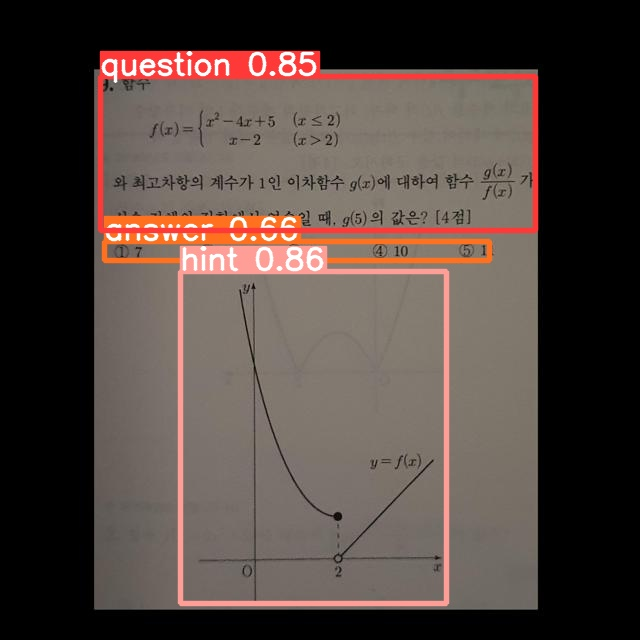

In [9]:
Image(filename='runs/detect/exp2/수학2_1_극한과 연속_9번.jpg', width=600)

## Local Logging

All results are logged by default to `runs/train`, with a new experiment directory created for each new training as `runs/train/exp2`, `runs/train/exp3`, etc. View train and test jpgs to see mosaics, labels, predictions and augmentation effects. Note a **Mosaic Dataloader** is used for training (shown below), a new concept developed by Ultralytics and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

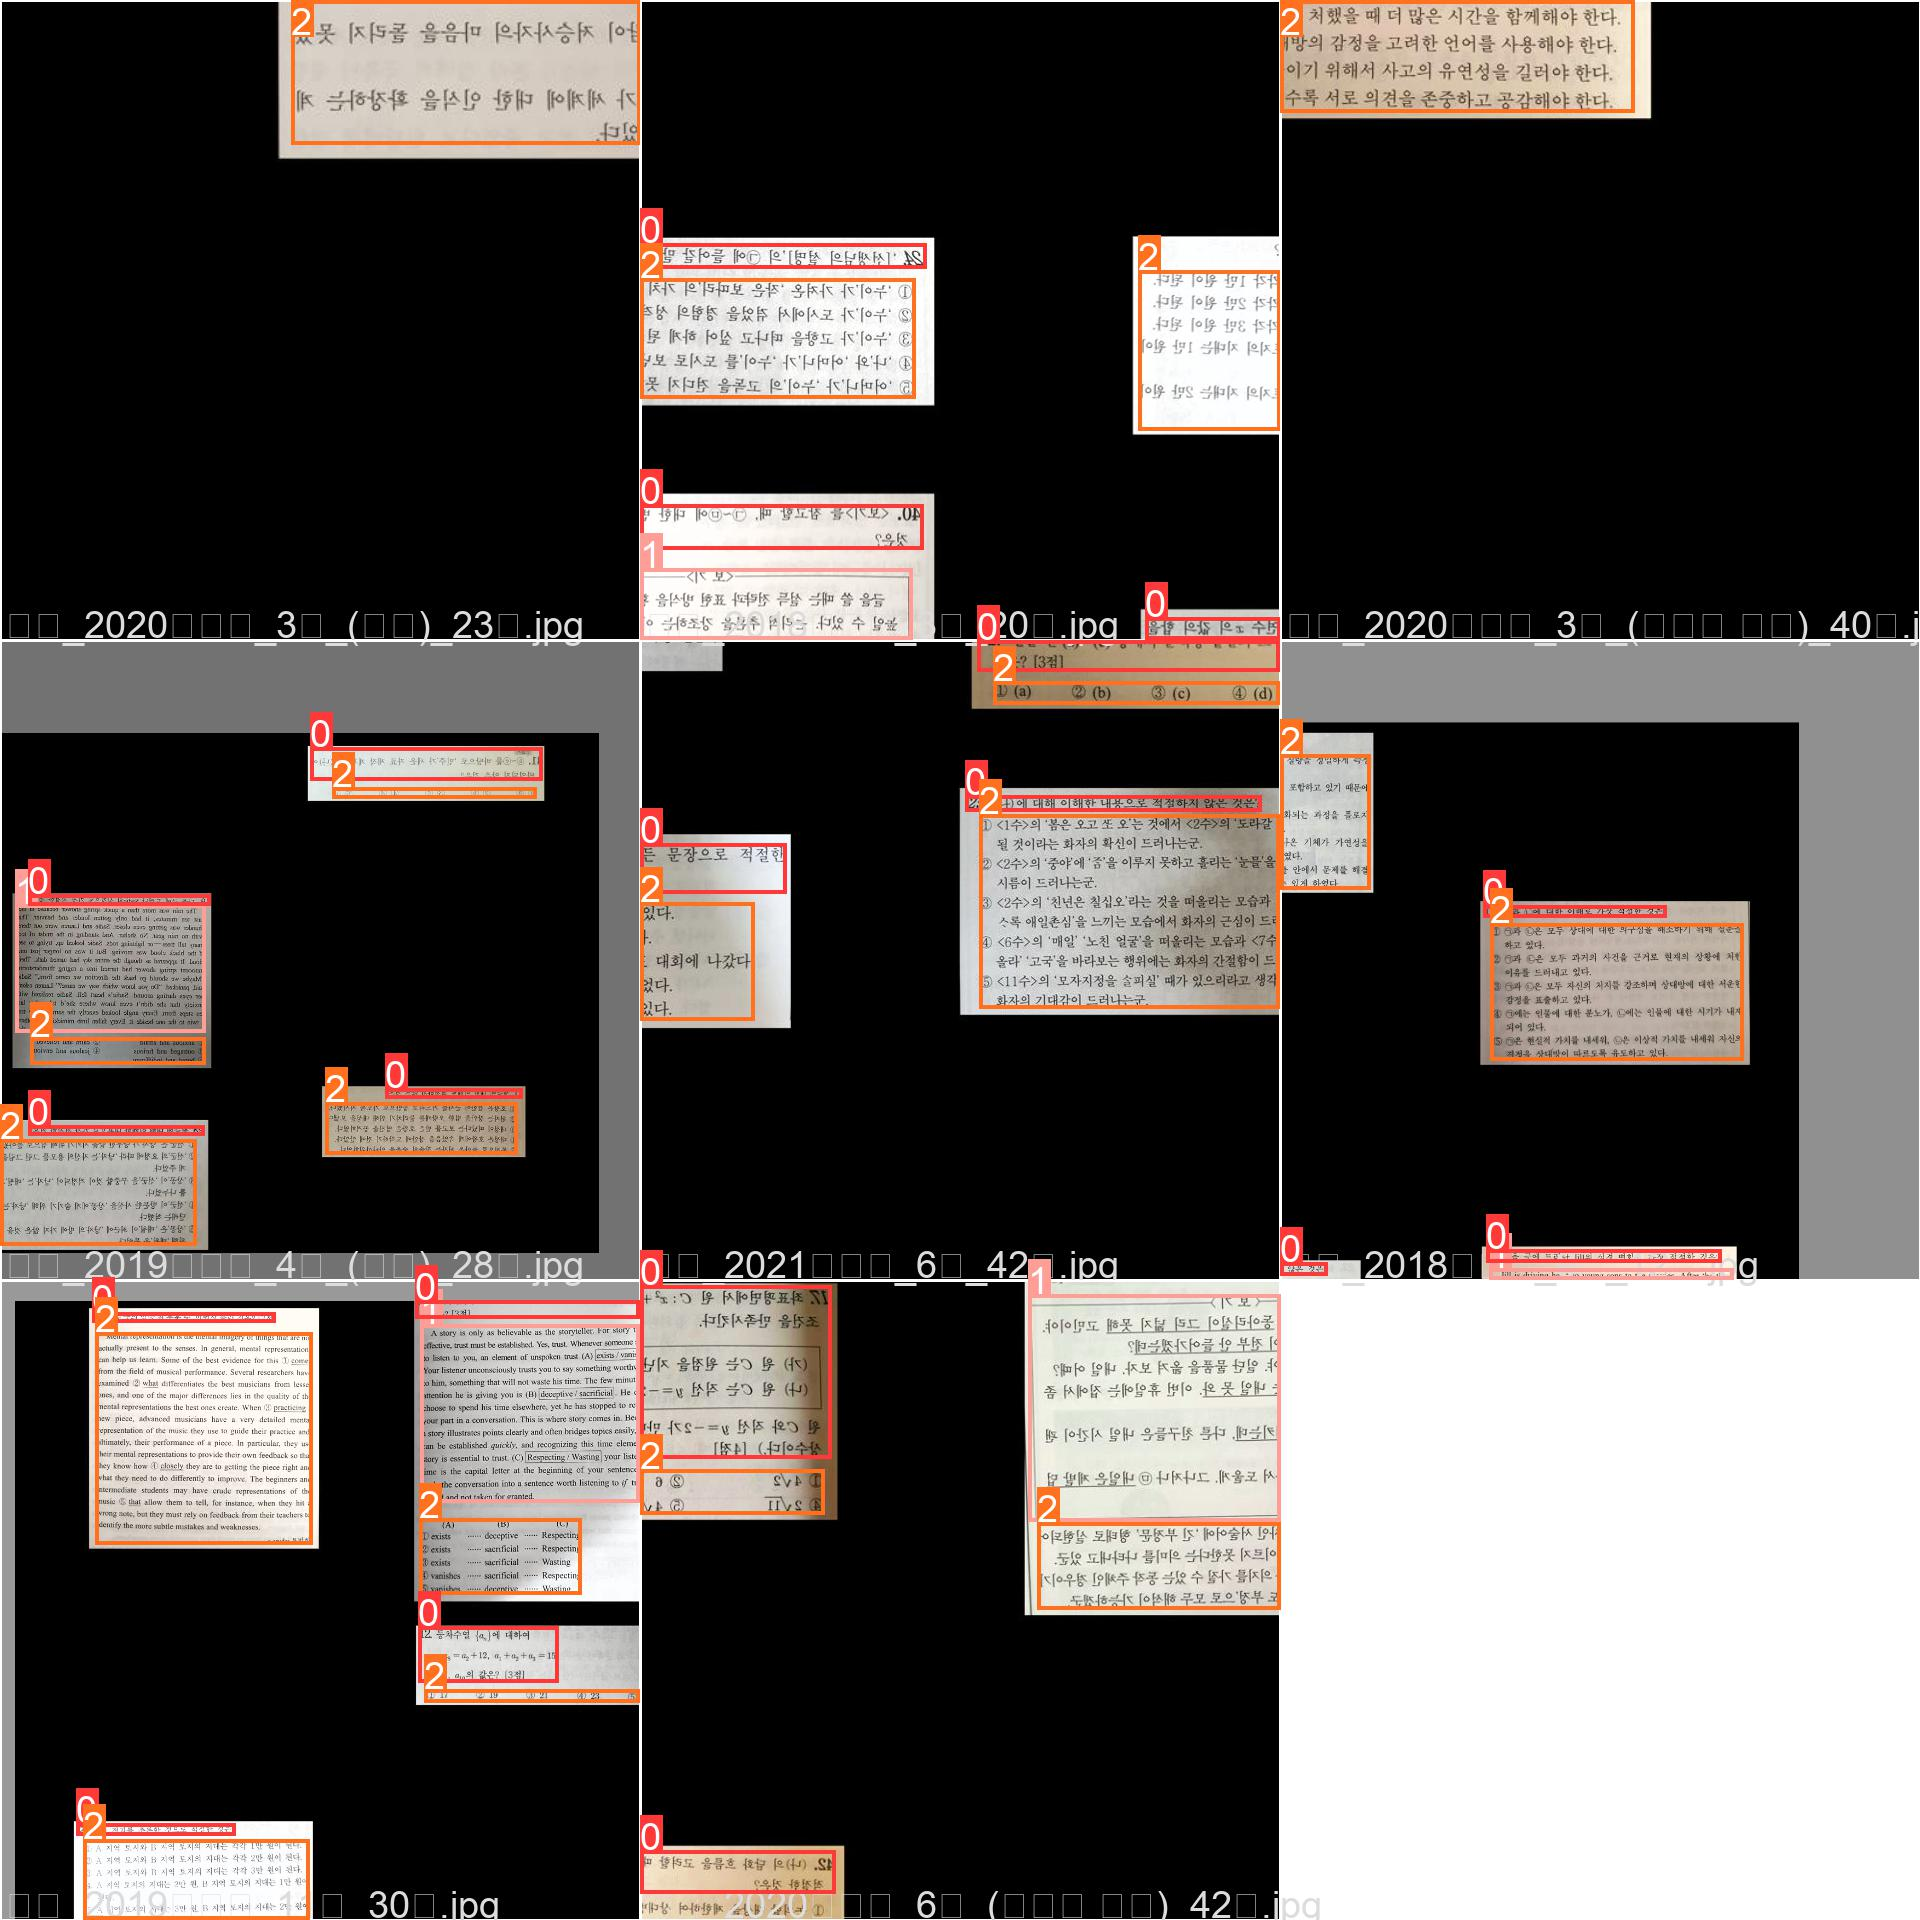

In [10]:
Image(filename='runs/train/exp/train_batch0.jpg', width=800)  # train batch 0 mosaics and labels

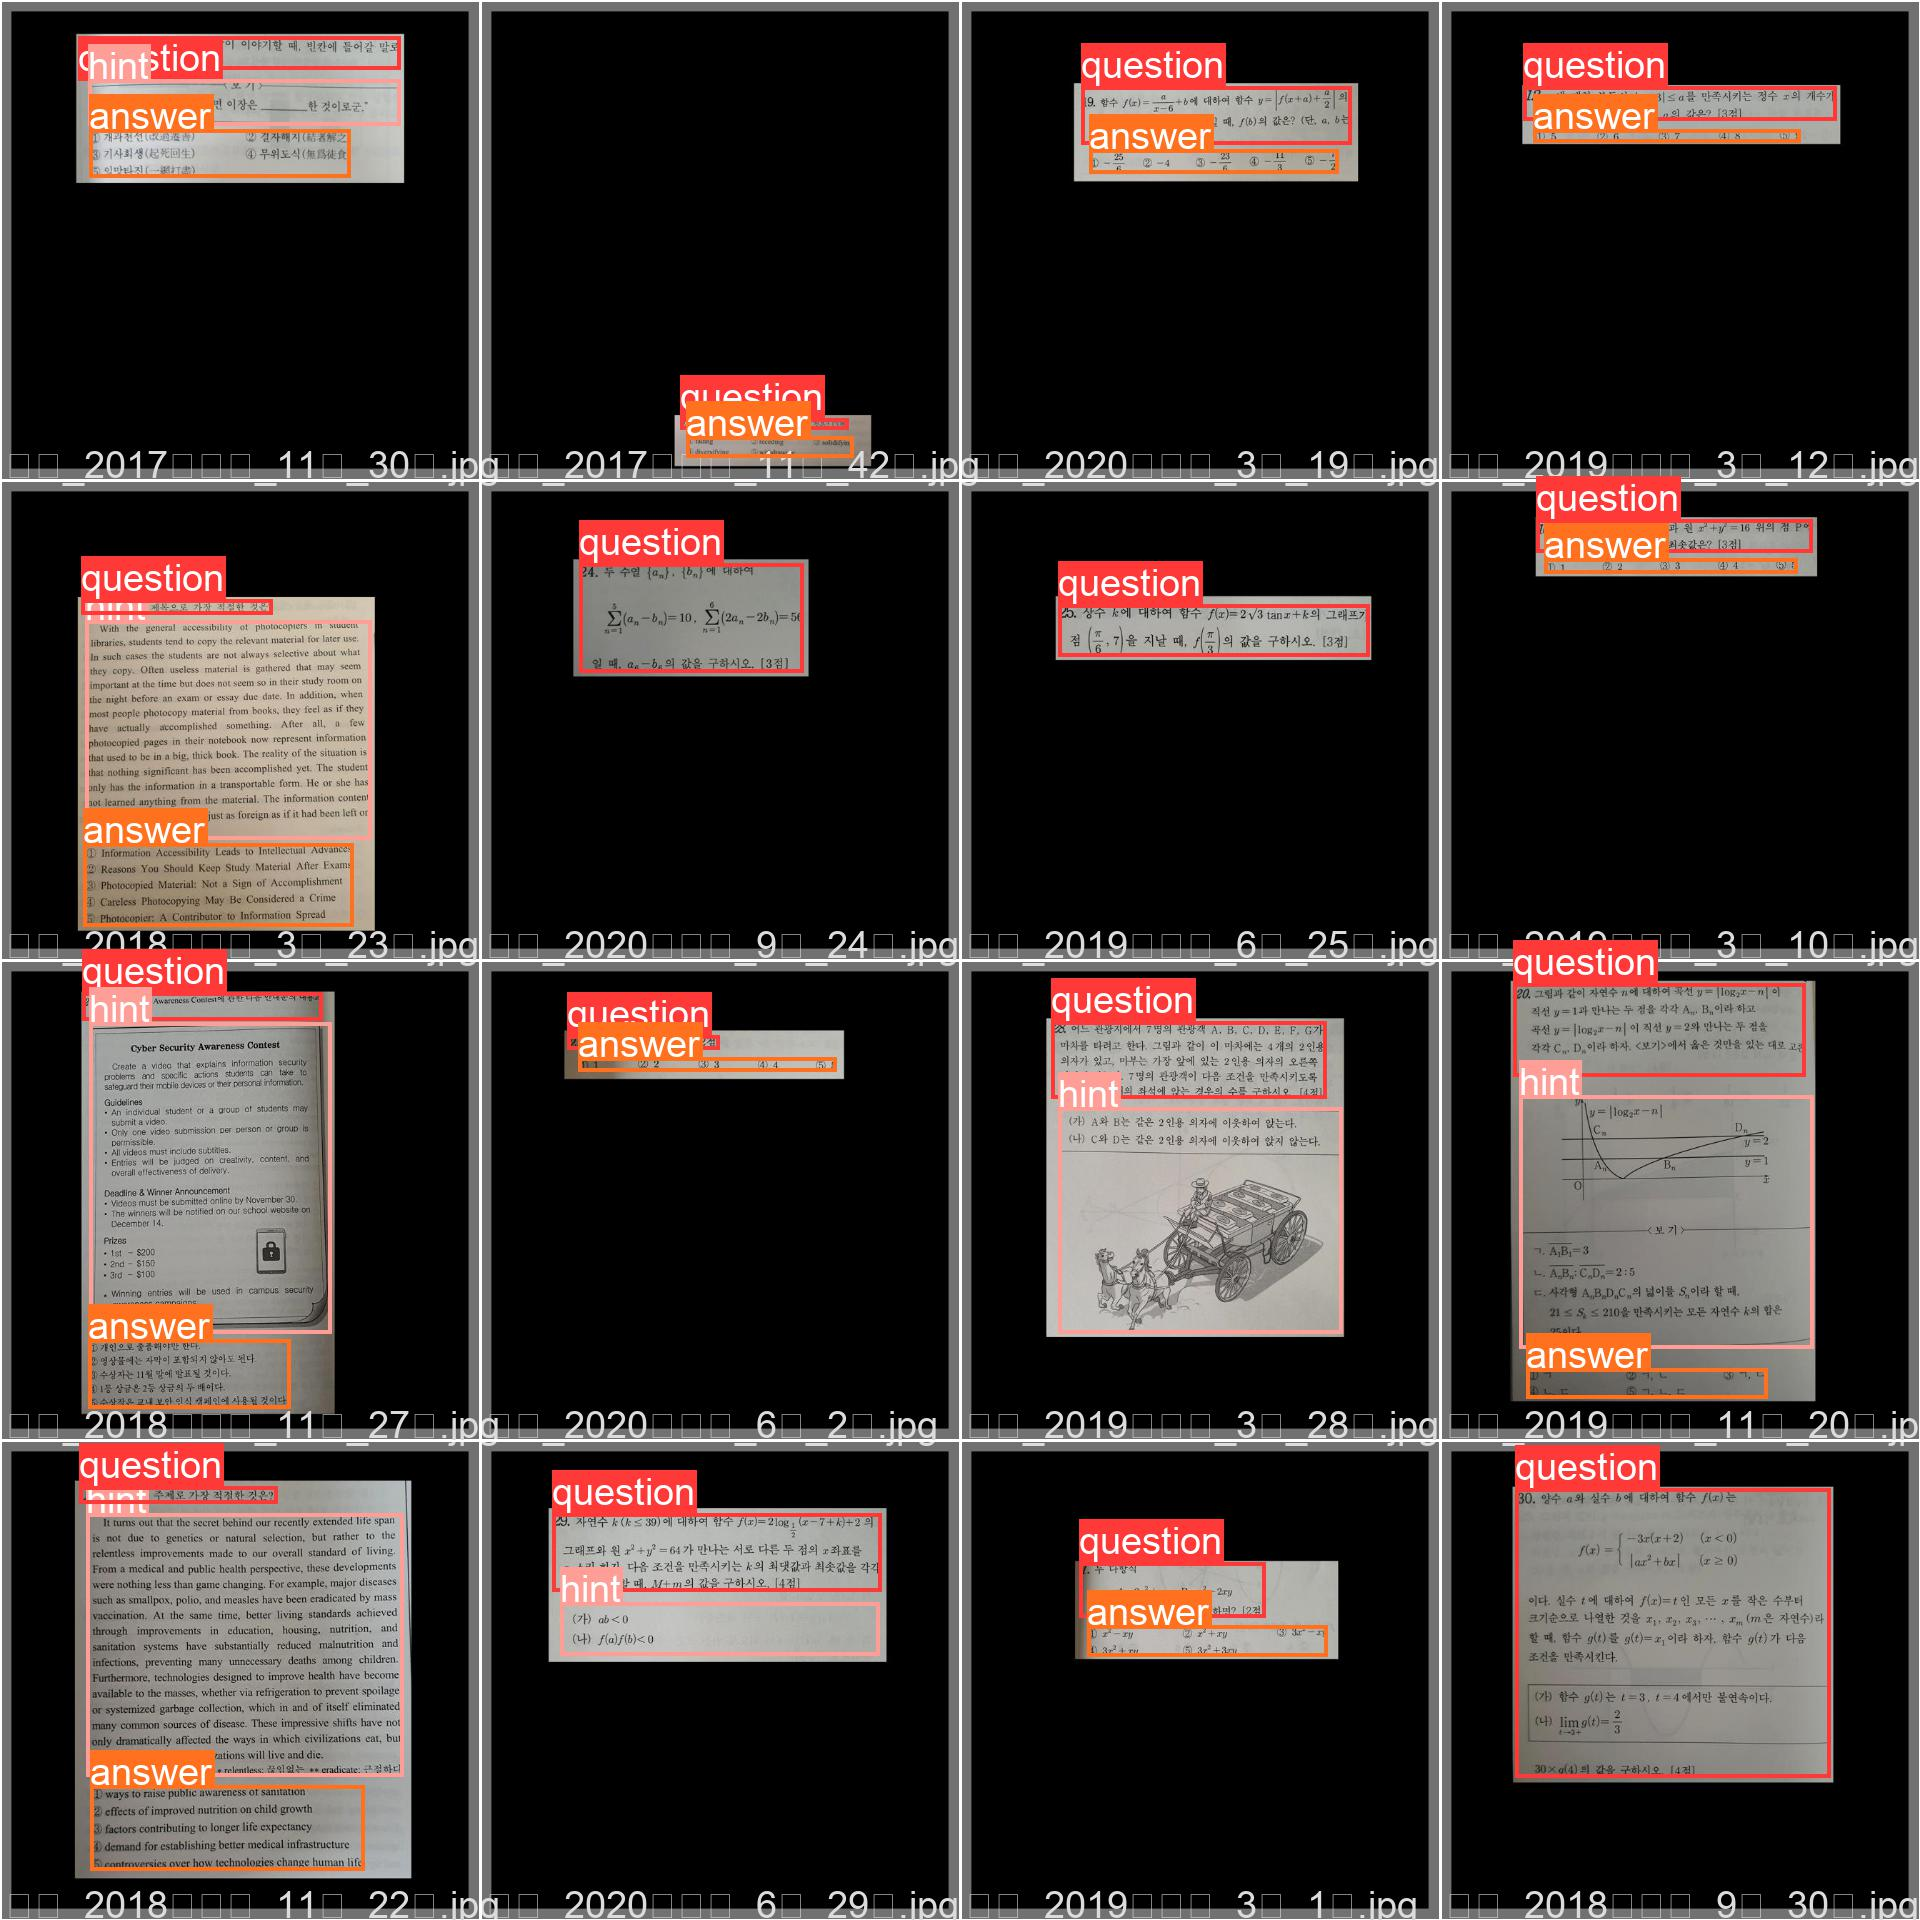

In [11]:
Image(filename='runs/train/exp/val_batch0_labels.jpg', width=800)  # test batch 0 labels

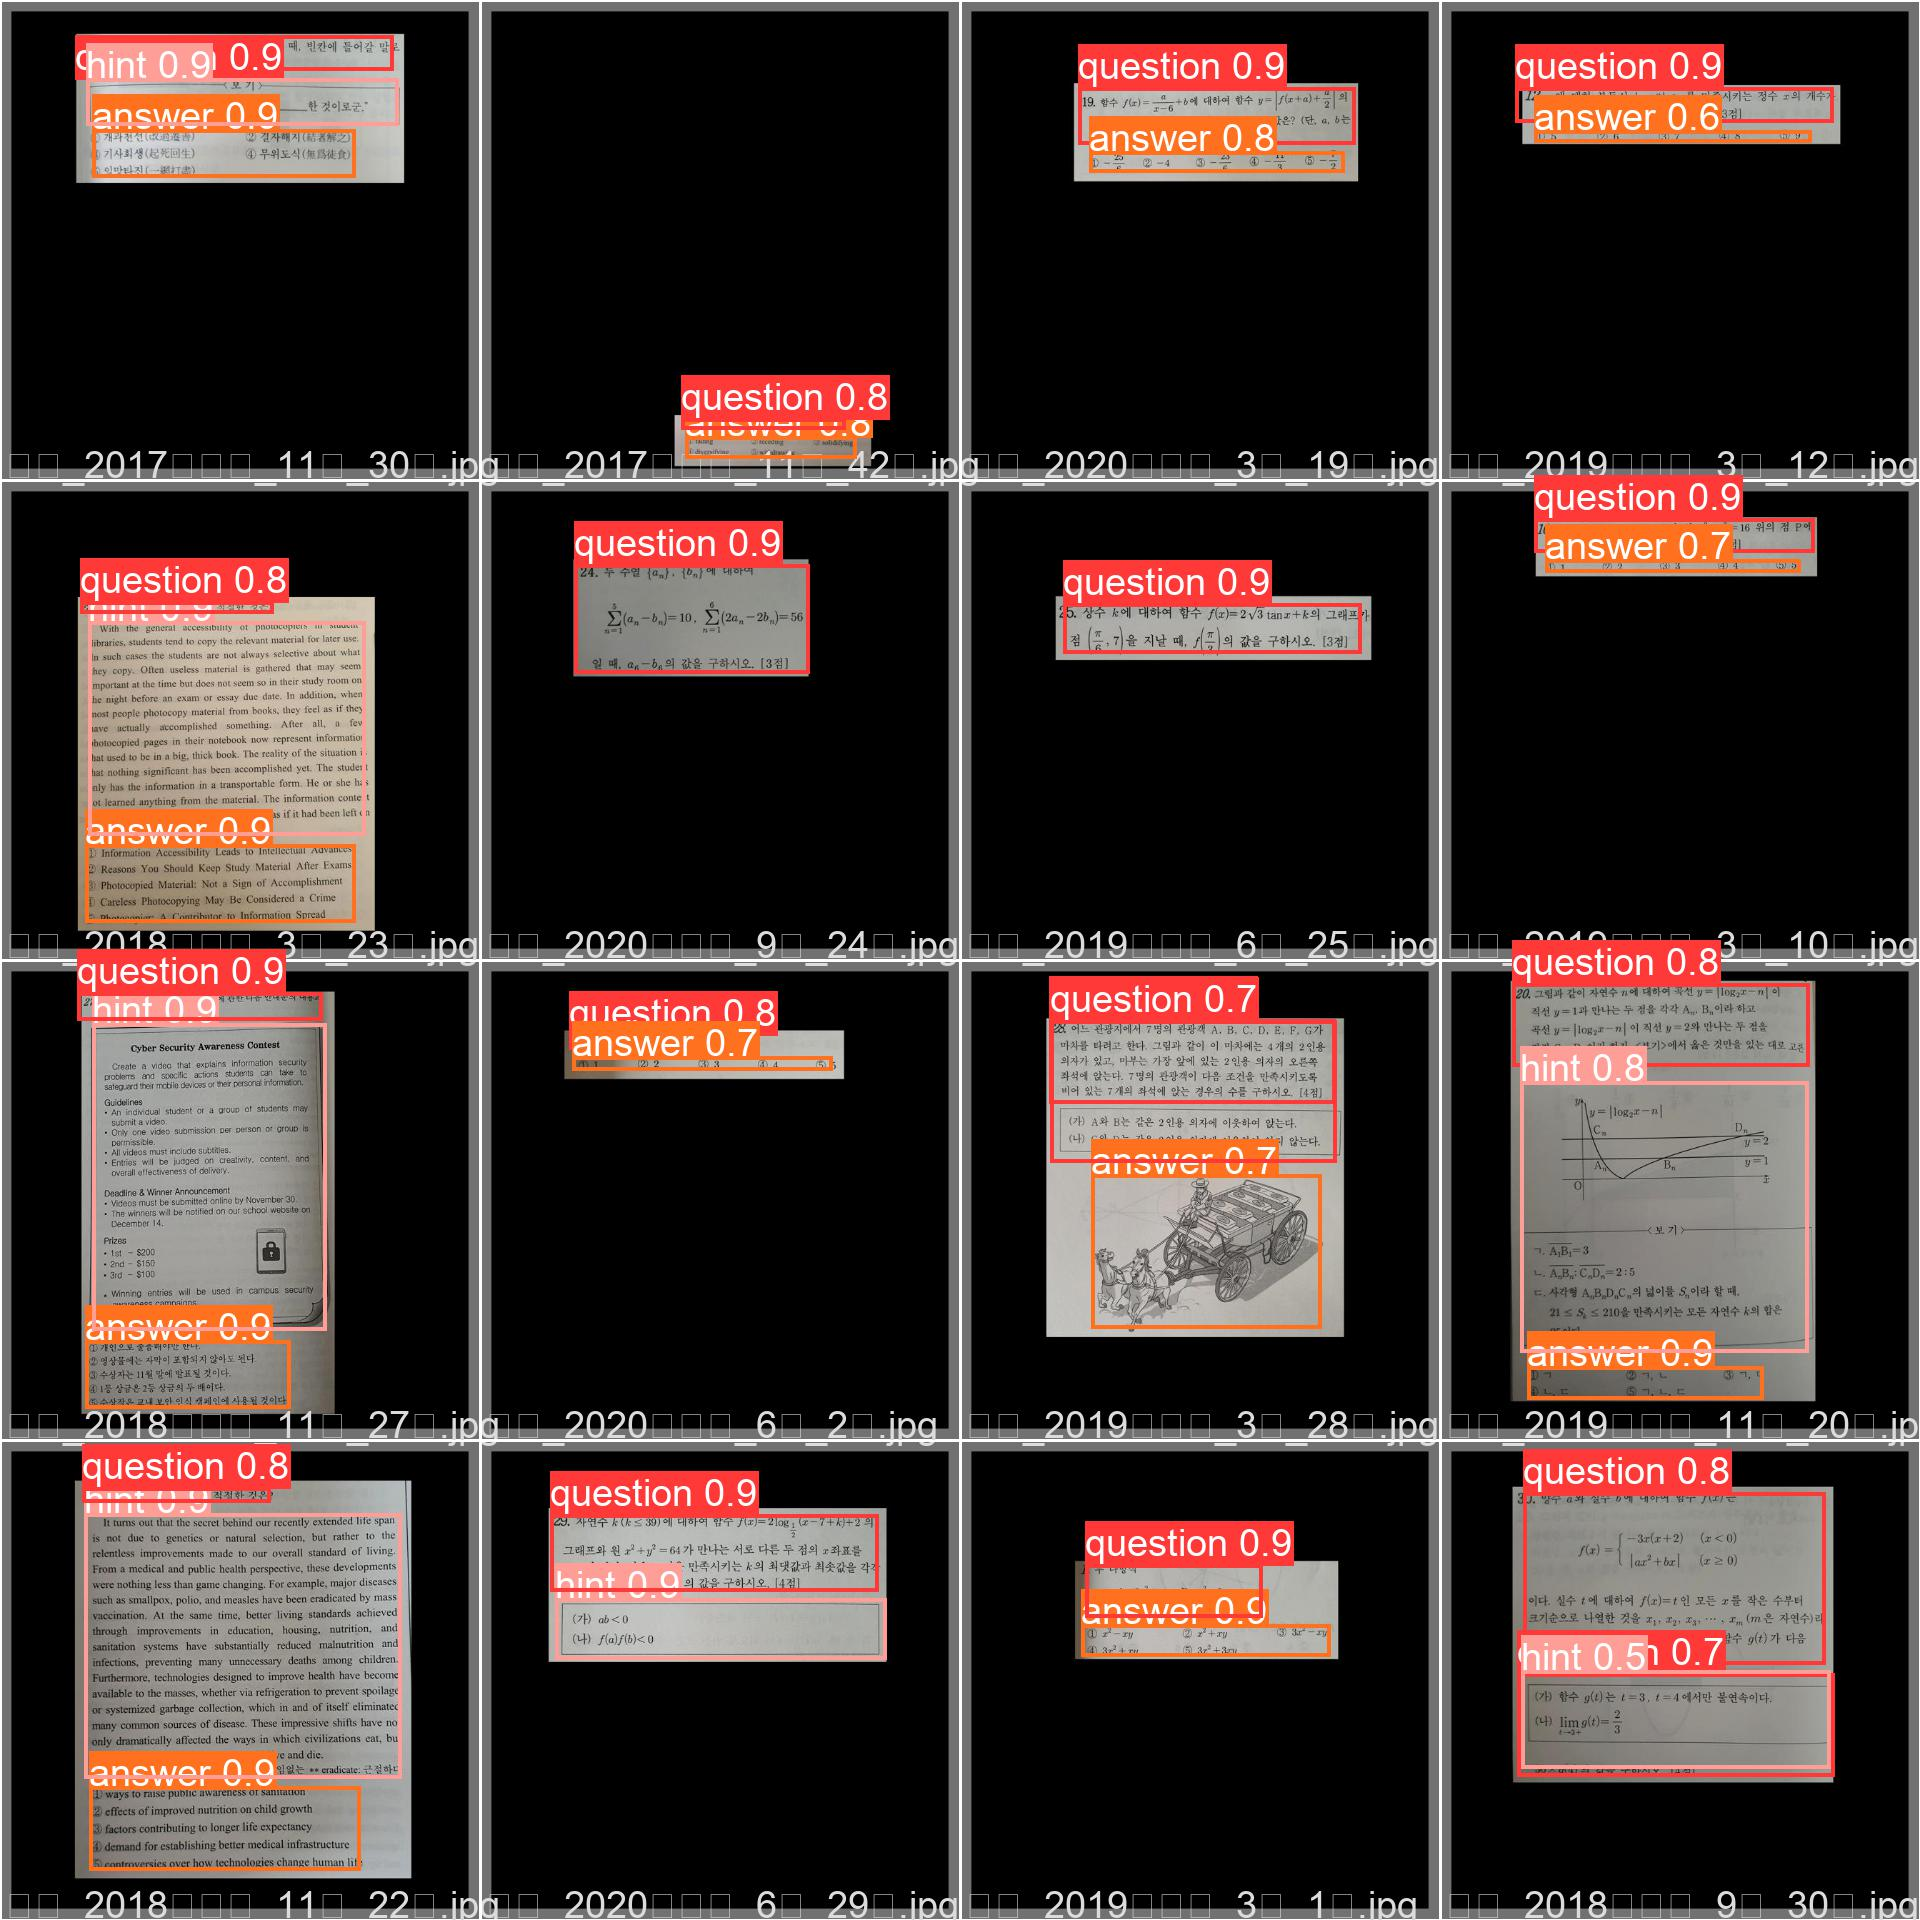

In [12]:
Image(filename='runs/train/exp/val_batch0_pred.jpg', width=800)  # test batch 0 predictions

Training losses and performance metrics are also logged to [Tensorboard](https://www.tensorflow.org/tensorboard) and a custom `results.txt` logfile which is plotted as `results.png` (below) after training completes. Here we show YOLOv5s trained on COCO128 to 300 epochs, starting from scratch (blue), and from pretrained `--weights yolov5s.pt` (orange).

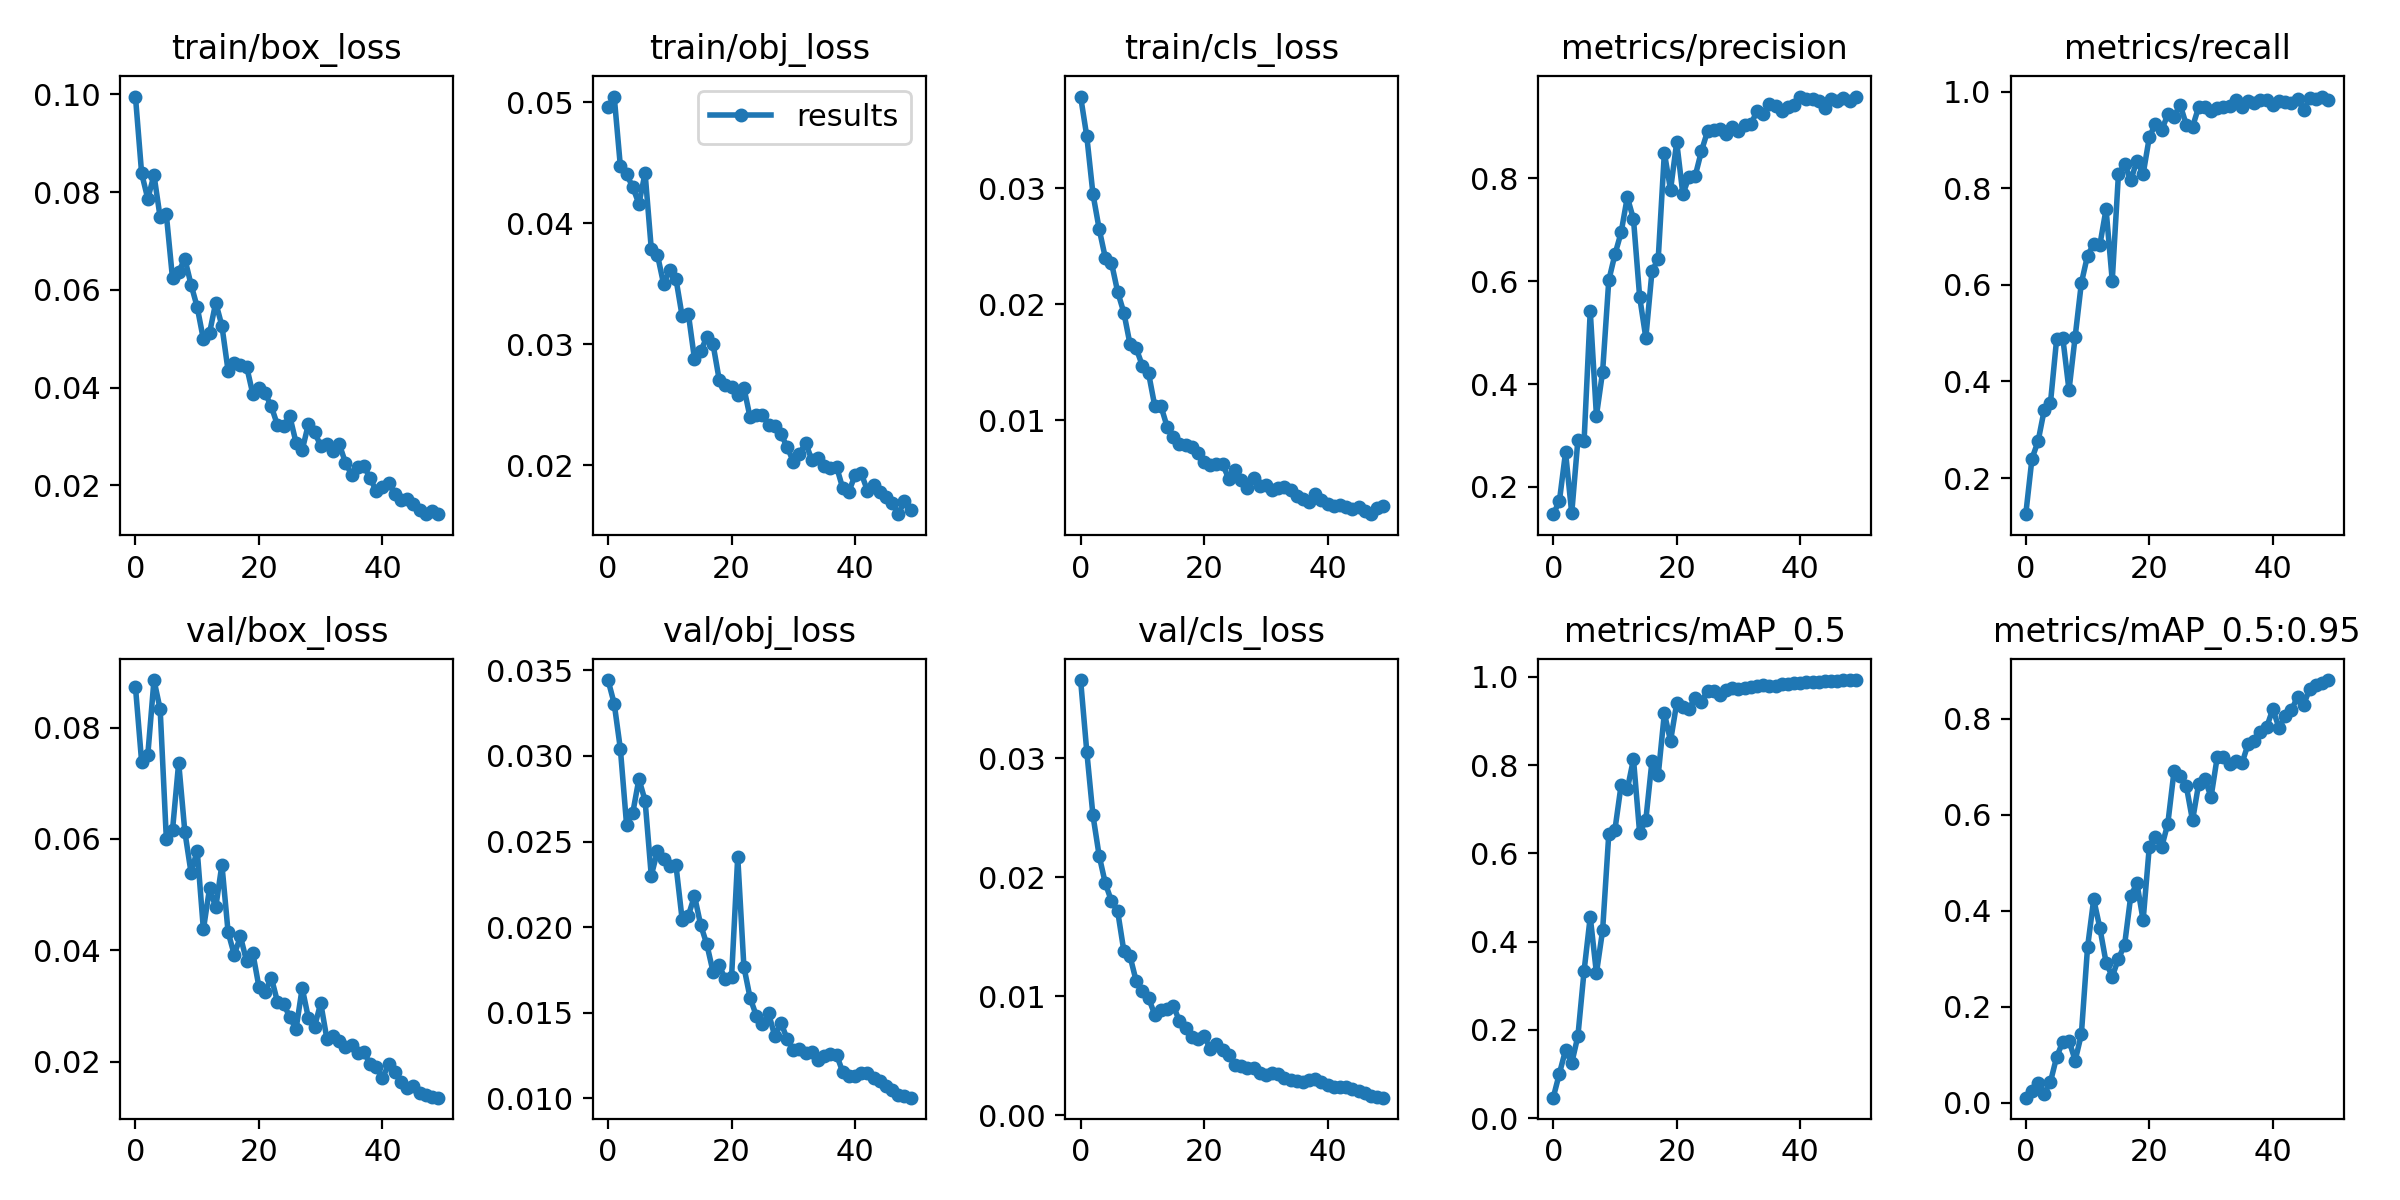

In [13]:
from utils.plots import plot_results 
plot_results('runs/train/exp/results.csv')  # plot all results*.txt as results.png
Image(filename='runs/train/exp/results.png', width=800)

In [14]:
# PyTorch Hub
import torch

# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

# Images
dir = 'https://github.com/ultralytics/yolov5/raw/master/data/images/'
imgs = [dir + f for f in ('zidane.jpg', 'bus.jpg')]  # batch of images

# Inference
results = model(imgs)
results.print()  # or .show(), .save()

results.xyxy[0]  # img1 predictions (tensor)
results.pandas().xyxy[0]  # img1 predictions (pandas)

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: scipy>=1.5 not found and is required by YOLOv5, attempting auto-update...

requirements: seaborn>=0.11.0 not found and is required by YOLOv5, attempting auto-update...

requirements: 3 packages updated per /content/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-5-9 torch 1.11.0+cu113 CUDA:0 (Tesla K80, 11441MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


image 1/2: 720x1280 2 persons, 2 ties
image 2/2: 1080x810 4 persons, 1 bus
Speed: 446.2ms pre-process, 20.3ms inference, 2.2ms NMS per image at shape (2, 3, 640, 640)


,xmin,ymin,xmax,ymax,confidence,class,name
0,742.550171,48.037018,1141.204712,716.641724,0.881825,0,person
1,442.059479,437.528076,496.809357,709.838989,0.687342,27,tie
2,125.191498,193.680603,711.992432,713.047058,0.639421,0,person
3,982.893005,308.356750,1027.368652,420.091736,0.262013,27,tie
